## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = [1024,512,256,128]
MOMENTUM = 0.95
from keras.optimizers import SGD

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for batch_ratio in BATCH_SIZE:
    keras.backend.clear_session()    
    print("Experiment with bath_size = %.6f" % (batch_ratio))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = SGD(lr= LEARNING_RATE, nesterov=True , momentum=MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train,y_train,
             epochs = EPOCHS,
             batch_size = batch_ratio,
             validation_data = (x_test,y_test),
             shuffle = True)
    # Collect results
    
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc  = model.history.history['acc']
    valid_acc  = model.history.history['val_acc']
    
    exp_name_tag = "exp-l1-%s" % str(batch_ratio)
    
    results[exp_name_tag] = {"train_loss":train_loss,
                             "valid_loss":valid_loss,
                             "train_acc" :train_acc,
                             "valid_acc" : valid_acc}

Experiment with bath_size = 1024.000000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________________________

50000/50000 [==============================] - 3s 64us/step - loss: 1.3762 - acc: 0.5178 - val_loss: 1.5387 - val_acc: 0.4538
Epoch 5/10
50000/50000 [==============================] - 3s 64us/step - loss: 1.3158 - acc: 0.5376 - val_loss: 1.5562 - val_acc: 0.4549
Epoch 6/10
50000/50000 [==============================] - 3s 63us/step - loss: 1.2674 - acc: 0.5545 - val_loss: 1.5275 - val_acc: 0.4654
Epoch 7/10
50000/50000 [==============================] - 3s 65us/step - loss: 1.2186 - acc: 0.5719 - val_loss: 1.4869 - val_acc: 0.4764
Epoch 8/10
50000/50000 [==============================] - 3s 63us/step - loss: 1.1774 - acc: 0.5879 - val_loss: 1.4644 - val_acc: 0.4826
Epoch 9/10
50000/50000 [==============================] - 3s 62us/step - loss: 1.1347 - acc: 0.6046 - val_loss: 1.4612 - val_acc: 0.4908
Epoch 10/10
50000/50000 [==============================] - 3s 66us/step - loss: 1.0966 - acc: 0.6168 - val_loss: 1.4668 - val_acc: 0.4873
Experiment with bath_size = 128.000000
____________

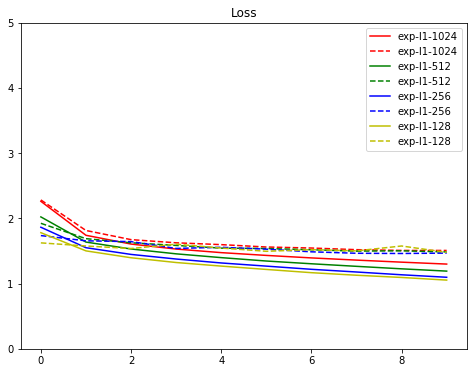

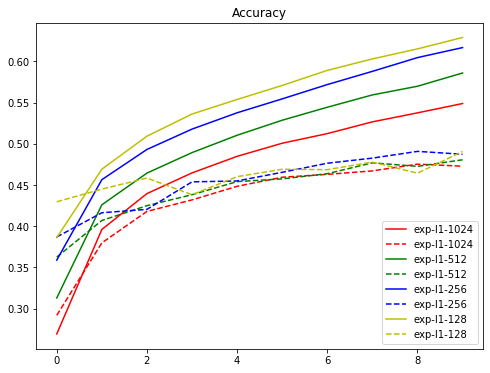

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()